<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Define-function" data-toc-modified-id="Define-function-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Define function</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load Data</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Flattening-The-Image" data-toc-modified-id="Flattening-The-Image-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Flattening The Image</a></span><ul class="toc-item"><li><span><a href="#Train-Test-Splitting" data-toc-modified-id="Train-Test-Splitting-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Train Test Splitting</a></span></li><li><span><a href="#Pipelining" data-toc-modified-id="Pipelining-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Pipelining</a></span></li></ul></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Precision,-Recall,-F1-score-and-Accuracy" data-toc-modified-id="Precision,-Recall,-F1-score-and-Accuracy-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Precision, Recall, F1-score and Accuracy</a></span></li></ul></li><li><span><a href="#Save-the-model" data-toc-modified-id="Save-the-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Save the model</a></span></li><li><span><a href="#Load-the-model" data-toc-modified-id="Load-the-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Load the model</a></span></li></ul></div>

In [2]:
import csv
from PIL import Image
import numpy as np
import os
import string
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearnex import patch_sklearn
from sklearn.svm import LinearSVC

from matplotlib import pyplot as plt

## Define function

In [4]:
# load image from csv and return image on folder
def csv_to_image(csv_path,csv_image_shape_initialized, image_shape_target, image_folder_path):
    
    '''
    something to note :
    - don't include the header on the csv data
    - each row save the image where the first column is the label followed the pixel value
    - this function just good at minimize image not to enlarge. since interpolation used are good for minimize
    
    args :
    csv_path : where the csv that will be loaded saved
    csv_image_shape : image_shape saved on the csv
    image_shape_target : size of the image you want as the output
    
    '''
    count = 1
    
    #get list alphabet
    Alphabet_Mapping_List = list(string.ascii_uppercase)
    
    # Make folder of each alphabet, if there no folder with a specific alphabel listed on Alphabel_Mapping_list then it will make new folder
    for alphabet in Alphabet_Mapping_List:
        path = image_folder_path + '/' + alphabet
        if not os.path.exists(path):
            os.makedirs(path)
    
    
    with open(csv_path, newline='') as csvfile:
        # make a object that can help to iterate over lines of CSV file
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        
        # Iterate over lines
        for row in reader:
            # in each row column 1 is the label and saved in index 0. so we need indexing to row 0 to get the label
            digit_Name = row[0]

            # in each row, column  2 to the end is the pixel of the image saved
            image_array = np.asarray(row[1:])
            
            #reshaping the array from (784,) to (28,28) since image should be 2 dimension atleast
            image_array = image_array.reshape(csv_image_shape_initialized)
            # buld image object 
            new_image = Image.fromarray(image_array.astype('uint8'))
            # Resize to the Image to the size we want
            new_image = new_image.resize(image_shape_target)
            
            #convert integer value being alphabel, example, if zero then "A", if 1 then "B"
            label = Alphabet_Mapping_List[int(digit_Name)]
            
            image_Path = image_folder_path + '/' + label + '/' + str(label) + '-' + str(count) + '.png'
            new_image.save(image_Path)
            count = count + 1

            if count % 1000 == 0:
                print ("Images processed: " + str(count))
  

In [5]:
#load image from folder and return stacked numpy array for handwritten recognition
def load_image(directory, image_folder_path=(24, 24)):
    
    '''
    args :
    - directory : directory path of all image folder saved
    - image_folder_path : target image you want as return

    return :
    stacked image aray with the label 
    '''
    
    total_image = 0
    label_names_list = [folder for folder in os.listdir(directory)]
    
    #Calculate how many image to make multidimensional Array
    for label_name in label_names_list :
        total_image += len(os.listdir(os.path.join(directory,label_name)))
    #Define array of image and target
    stack_of_image = np.empty((total_image,image_shape_target[0],image_shape_target[1]))
    stack_of_label = np.empty(total_image)
    
    temp = total_image 
    for i, label_name  in enumerate(label_names_list) :
        image_class_path = os.path.join(directory,label_name)
    for image in os.listdir(image_class_path) :
        image = os.path.join(image_class_path,image)
        #Open Image
        image = Image.open(image)
        #Resize Image
        resized_image = image.resize(image_shape_target)
        resized_image_array = np.asarray(resized_image)
        #Append to Array
        stack_of_image[total_image-temp] = resized_image_array
        stack_of_label[total_image-temp] = i
        temp -= 1       
    
    return (stack_of_image, stack_of_label)
  

In [6]:
# Load Image from csv and return stacked numpy array for handwritten recognition
def csv_to_array(csv_path,csv_image_shape_initialized, image_shape_target):
    
    '''
    something to note :
    - don't include the header on the csv data
    - each row save the image where the first column is the label followed the pixel value
    - this function just good at minimize image not to enlarge. since interpolation used are good for minimize
    
    args :
    csv_path : where the csv that will be loaded saved
    csv_image_shape_initialized : image_shape saved on the csv
    image_shape_target : size of the image you want as the output
    
    '''
    
    count = 1
    X_stacked = []
    y_stacked = []
    
    with open(csv_path, newline='') as csvfile:
        # make a object that can help to iterate over lines of CSV file
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        
        # Iterate over lines
        for row in reader:
            # in each row column 1 is the label and saved in index 0. so we need indexing to row 0 to get the label
            y_stacked.append(int(row[0]))

            # in each row, column  2 to the end is the pixel of the image saved
            image_array = np.asarray(row[1:])
            
            #reshaping the array from (784,) to (28,28) since image should be 2 dimension atleast
            image_array = image_array.reshape(csv_image_shape_initialized)
            # buld image object 
            new_image = Image.fromarray(image_array.astype('uint8'))
            # Resize to the Image to the size we want
            new_image = new_image.resize(image_shape_target)
            
            # Append to the list
            X_stacked.append(np.array(new_image))
            
        X_stacked = np.array(X_stacked)
        y_stacked = np.array(y_stacked)
        
    return X_stacked, y_stacked

## Data Preparation

In [7]:
#path of csv located
csv_path = r"C:/Users/Astrowest/Downloads/A_Z.csv"
#Image shape initialize by the data author
csv_image_shape_initialized = (28,28)
#Image shape you want as the output
image_shape_target =(24,24)
#Image path to loaded from
image_folder_path = r"/notebooks/Handwritten Recognition/data_input/A_Z Image"

In [13]:
# Run this code to convert the CSV file to image 
csv_to_image(csv_path,csv_image_shape_initialized, image_shape_target, image_folder_path)

KeyboardInterrupt: 

### Load Data

In [1]:
# Run this code to load code from directory and saved to array for Handwritten recognition
X, y = load_image(directory, image_folder_path=(24, 24))


NameError: name 'image_to_array' is not defined

In [12]:
# Run this code to Load code from csv and save to array for Handwritten recognition
X, y = csv_to_array(csv_path,csv_image_shape_initialized, image_shape_target)


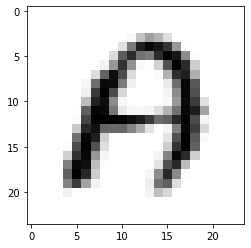

In [13]:
# show the image
plt.imshow(X[2], cmap= 'binary')

## Modeling

### Flattening The Image

In [14]:
# Image need to flattened before classify
# (num_of_image,width, height) -> (num_of_image, width*height)
X = X.reshape(X.shape[0], X.shape[1]* X.shape[2])

#### Train Test Splitting

In [15]:
# Splitting between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123321)

#### Pipelining 

In [17]:
# Activate Intel Extension so the algorith can run faster
patch_sklearn()

# define the algorithm
linearsvc =  LinearSVC(random_state=0, tol=1e-5)

# so the step each image will follow this step before can be trained or inference
svc_steps = [ 
    ('scaler', StandardScaler()),
    ('classify', linearsvc)
]

# build pipeline from the svc_steps
svc_pipe = Pipeline(svc_steps)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [18]:
# Train the model
svc_pipe.fit(X_train, y_train)

c:\Users\Astrowest\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('classify', LinearSVC(random_state=0, tol=1e-05))])

## Evaluation

In [19]:
# Predict the test data
y_pred = svc_pipe.predict(X_test)

### Precision, Recall, F1-score and Accuracy

In [24]:
print("======================= SVC Model Report ===========================\n")
print(classification_report(y_test, y_pred))

======================= SVC Model Report ===========================

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      2751
           1       0.81      0.66      0.73      1737
           2       0.87      0.89      0.88      4760
           3       0.75      0.67      0.71      2030
           4       0.80      0.75      0.78      2267
           5       0.92      0.78      0.85       241
           6       0.80      0.71      0.75      1143
           7       0.71      0.66      0.69      1407
           8       0.86      0.82      0.84       230
           9       0.76      0.67      0.71      1706
          10       0.78      0.69      0.73      1101
          11       0.92      0.95      0.93      2284
          12       0.85      0.88      0.87      2449
          13       0.78      0.78      0.78      3805
          14       0.89      0.96      0.92     11611
          15       0.86      0.91      0.88      3872
          1

## Save the model

In [17]:
filename = 'svc_model.sav'

In [ ]:
# save the model to disk
pickle.dump(svc_pipe, open(filename, 'wb'))

## Load the model

In [18]:
# load the model from disk
svc_pipe = pickle.load(open(filename, 'rb'))